<a href="https://colab.research.google.com/github/adammoss/MLiS2/blob/master/examples/rnn/timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this example we will use RNN models (vanilla and LSTM) in TF2 to forecast the Tesla (TSLA) stock price.  It is based on the time series example at https://www.tensorflow.org/tutorials/structured_data/time_series. 

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [0]:
tf.random.set_seed(1)

In [427]:
print(tf.__version__)

2.1.0


Read in CSV file using Pandas

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/adammoss/MLiS2/master/examples/rnn/TSLA.csv')

In [429]:
len(df)

2429

In [430]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


Define function to extract many-to-one training data examples

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [432]:
uni_data = df['Close']
uni_data.index = df['Date']
uni_data.head()

Date
2010-06-29    23.889999
2010-06-30    23.830000
2010-07-01    21.959999
2010-07-02    19.200001
2010-07-06    16.110001
Name: Close, dtype: float64

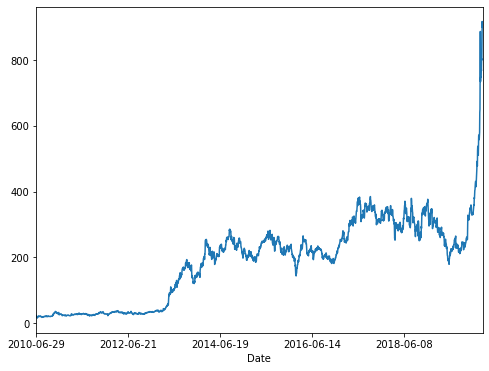

In [433]:
uni_data.plot()

In [0]:
uni_data = uni_data.values

Using first 2000 examples as training data

In [0]:
TRAIN_SPLIT = 2000

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Standardise the data

In [0]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Use the last N observations to learn to predict the value at the next time step.

In [0]:
univariate_past_history = 100
univariate_future_target = 0

X_train, Y_train = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
X_test, Y_test = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [439]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1900, 100, 1)
(1900,)
(329, 100, 1)
(329,)


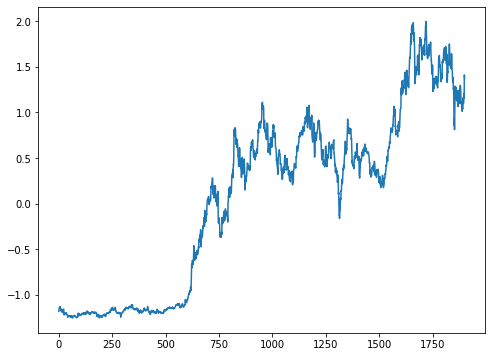

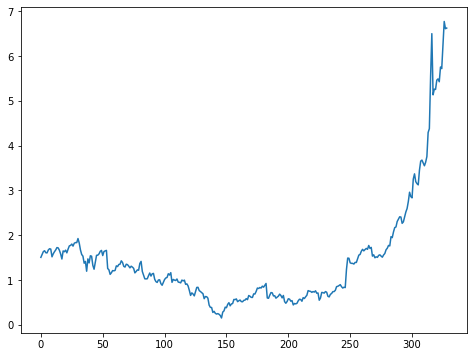

In [440]:
plt.plot(Y_train[:])
plt.show()
plt.plot(Y_test[:])
plt.show()

In [441]:
print ('Single window of past history')
print (X_train[0])
print ('\n Target value to predict')
print (Y_train[0])

Single window of past history
[[-1.23801939]
 [-1.23855722]
 [-1.25532006]
 [-1.28006089]
 [-1.30775989]
 [-1.31053877]
 [-1.29565841]
 [-1.29619624]
 [-1.29933368]
 [-1.28956283]
 [-1.27432389]
 [-1.2738757 ]
 [-1.26715264]
 [-1.25576825]
 [-1.27020043]
 [-1.27091755]
 [-1.26392556]
 [-1.26132597]
 [-1.26437376]
 [-1.26795941]
 [-1.26643551]
 [-1.26975221]
 [-1.27342748]
 [-1.26464269]
 [-1.25540968]
 [-1.2615949 ]
 [-1.2688558 ]
 [-1.27656491]
 [-1.27647527]
 [-1.28158479]
 [-1.2917142 ]
 [-1.29440343]
 [-1.28794929]
 [-1.28382581]
 [-1.28050911]
 [-1.28391545]
 [-1.28373616]
 [-1.28095731]
 [-1.27172432]
 [-1.28006089]
 [-1.27378605]
 [-1.27513066]
 [-1.27557885]
 [-1.27405496]
 [-1.27755096]
 [-1.2688558 ]
 [-1.26338773]
 [-1.26347737]
 [-1.26804903]
 [-1.26482197]
 [-1.26652515]
 [-1.27136575]
 [-1.26643551]
 [-1.26284986]
 [-1.25514077]
 [-1.2644634 ]
 [-1.2708279 ]
 [-1.26338773]
 [-1.2659873 ]
 [-1.27405496]
 [-1.27683384]
 [-1.27199323]
 [-1.26813867]
 [-1.26033993]
 [-1.25514

In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

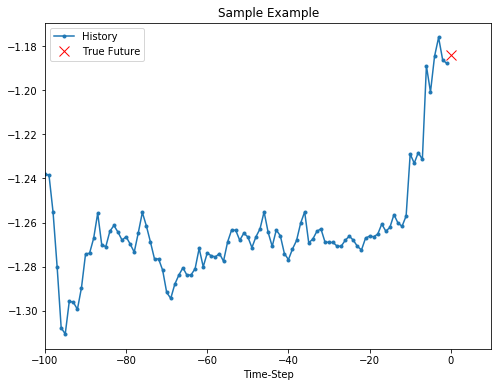

In [444]:
plot = show_plot([X_train[0], Y_train[0]], 0, 'Sample Example')
plot.show()

In [0]:
def build_model(RNN, hidden_units, recurrent_dropout):
  model = tf.keras.models.Sequential([
    RNN(hidden_units, input_shape=X_train.shape[-2:], recurrent_dropout=recurrent_dropout),
    tf.keras.layers.Dense(1)
  ])

  model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
  return model

First try a vanilla RNN model


In [0]:
rnn_model = build_model(tf.keras.layers.SimpleRNN, 8, 0.5)

In [447]:
rnn_model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_11 (SimpleRNN)    (None, 8)                 80        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [0]:
EPOCHS = 30

In [449]:
history = rnn_model.fit(X_train, Y_train, epochs=EPOCHS, validation_data=(X_test, Y_test))

Train on 1900 samples, validate on 329 samples
Epoch 1/30
1900/1900 [==============================] - 2s 1ms/sample - loss: 2.6100 - mae: 1.4022 - mse: 2.6100 - val_loss: 7.0767 - val_mae: 2.2855 - val_mse: 7.0767
Epoch 2/30
1900/1900 [==============================] - 1s 768us/sample - loss: 2.4187 - mae: 1.3545 - mse: 2.4187 - val_loss: 6.0512 - val_mae: 2.0824 - val_mse: 6.0512
Epoch 3/30
1900/1900 [==============================] - 1s 753us/sample - loss: 2.0158 - mae: 1.2312 - mse: 2.0158 - val_loss: 5.1980 - val_mae: 1.8974 - val_mse: 5.1980
Epoch 4/30
1900/1900 [==============================] - 1s 770us/sample - loss: 1.6527 - mae: 1.1146 - mse: 1.6527 - val_loss: 4.4771 - val_mae: 1.7268 - val_mse: 4.4771
Epoch 5/30
1900/1900 [==============================] - 1s 782us/sample - loss: 1.3830 - mae: 1.0045 - mse: 1.3830 - val_loss: 3.8732 - val_mae: 1.5706 - val_mse: 3.8732
Epoch 6/30
1900/1900 [==============================] - 2s 797us/sample - loss: 1.2058 - mae: 0.9368 - ms

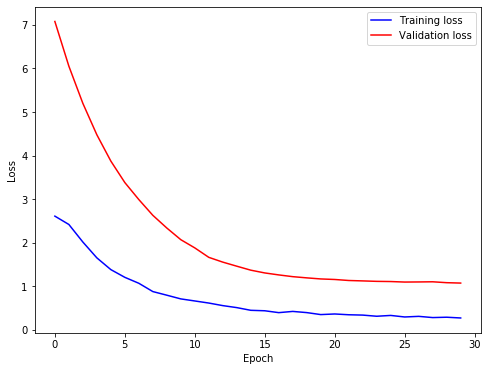

In [450]:
plt.figure()
plt.plot(range(len(history.history['loss'])), history.history['loss'], 'b', label='Training loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

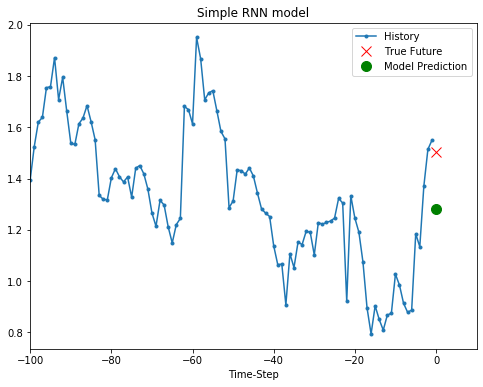

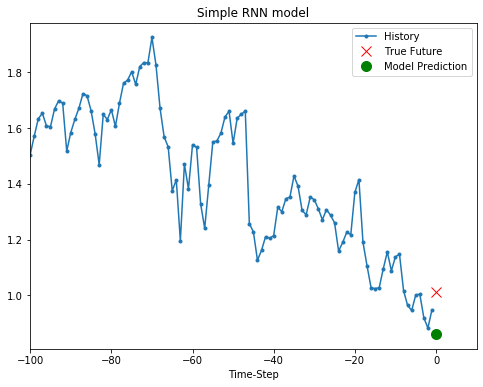

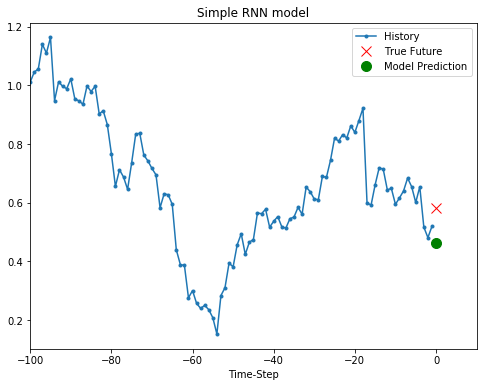

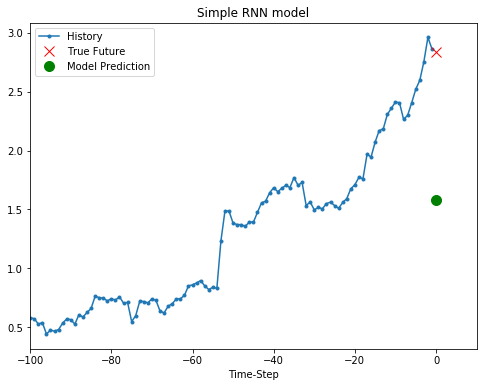

In [451]:
for i in [0, 100, 200, 300]:
  plot = show_plot([X_test[i], Y_test[i],
                    rnn_model.predict(X_test[i:i+1])[0]], 0, 'Simple RNN model')
  plot.show()


In [0]:
lstm_model = build_model(tf.keras.layers.LSTM, 8, 0.5)

In [453]:
lstm_model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 8)                 320       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [454]:
history = lstm_model.fit(X_train, Y_train, epochs=EPOCHS, validation_data=(X_test, Y_test))

Train on 1900 samples, validate on 329 samples
Epoch 1/30
1900/1900 [==============================] - 6s 3ms/sample - loss: 0.9054 - mae: 0.8340 - mse: 0.9054 - val_loss: 2.6353 - val_mae: 1.1585 - val_mse: 2.6353
Epoch 2/30
1900/1900 [==============================] - 4s 2ms/sample - loss: 0.3397 - mae: 0.4708 - mse: 0.3397 - val_loss: 1.8515 - val_mae: 0.7907 - val_mse: 1.8515
Epoch 3/30
1900/1900 [==============================] - 4s 2ms/sample - loss: 0.1431 - mae: 0.2859 - mse: 0.1431 - val_loss: 1.5502 - val_mae: 0.6521 - val_mse: 1.5502
Epoch 4/30
1900/1900 [==============================] - 4s 2ms/sample - loss: 0.0913 - mae: 0.2281 - mse: 0.0913 - val_loss: 1.3628 - val_mae: 0.5701 - val_mse: 1.3628
Epoch 5/30
1900/1900 [==============================] - 4s 2ms/sample - loss: 0.0659 - mae: 0.1925 - mse: 0.0659 - val_loss: 1.2503 - val_mae: 0.5221 - val_mse: 1.2503
Epoch 6/30
1900/1900 [==============================] - 4s 2ms/sample - loss: 0.0499 - mae: 0.1664 - mse: 0.0499 

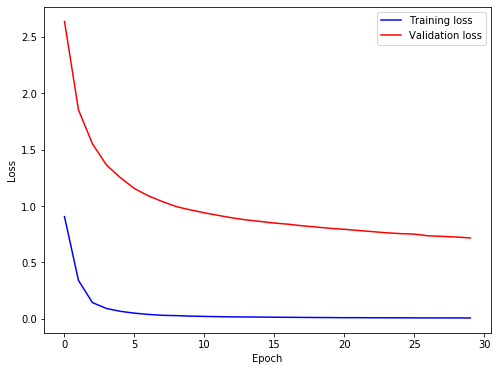

In [455]:
plt.figure()
plt.plot(range(len(history.history['loss'])), history.history['loss'], 'b', label='Training loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

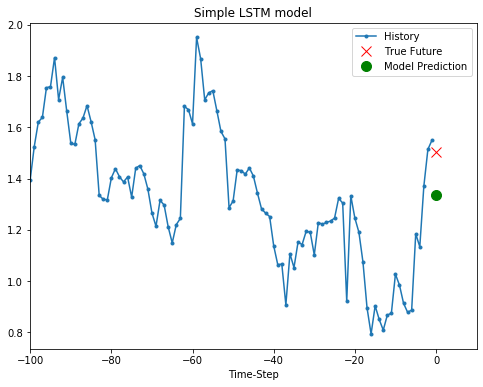

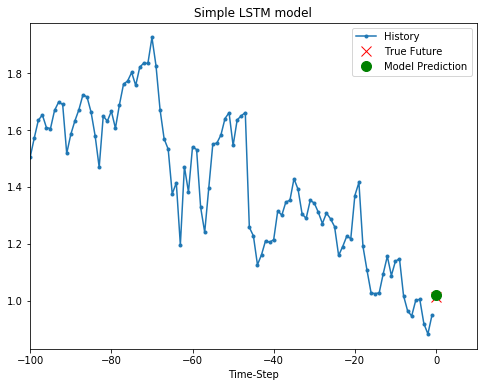

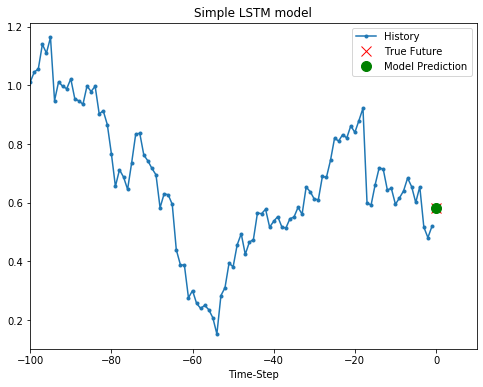

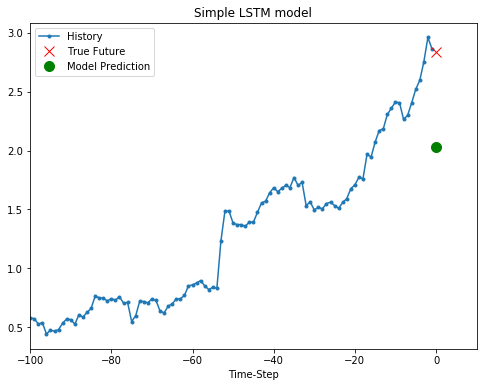

In [456]:
for i in [0, 100, 200, 300]:
  plot = show_plot([X_test[i], Y_test[i],
                    lstm_model.predict(X_test[i:i+1])[0]], 0, 'Simple LSTM model')
  plot.show()
